# **Import Library**

In [2]:
import cv2
from PIL import Image, ImageFile
import skimage
from skimage.transform import resize
from skimage.transform import rotate, warp

In [3]:
import keras
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

# **Upload Data dari Kaggle**

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadzulzhafran","key":"5686cda5cf3ae2a4d173988f5d2bc804"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d bmadushanirodrigo/fracture-multi-region-x-ray-data

Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data
License(s): ODC Public Domain Dedication and Licence (PDDL)


In [7]:
!unzip -q fracture-multi-region-x-ray-data.zip -d bone-fracture-dataset

# **Data Pre-processing**

In [8]:
TRAIN_DIR = 'bone-fracture-dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
VAL_DIR   = 'bone-fracture-dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'
TEST_DIR  = 'bone-fracture-dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

## **Augmentasi & Generator**

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False
)

Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [10]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# **Modelling**

## **Model Arsitektur CNN**

In [11]:
tf.keras.backend.clear_session()
model = Sequential()

# 1st Convolutional layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224,224,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers + Dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00009),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,816,961 (98.48 MB)

 Trainable params: 25,816,513 (98.48 MB)

 Non-trainable params: 448 (1.75 KB)

## **Training Model**

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6557 - loss: 1.2252

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


289/289 ━━━━━━━━━━━━━━━━━━━━ 76s 229ms/step - accuracy: 0.6559 - loss: 1.2238 - val_accuracy: 0.6647 - val_loss: 0.9088
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 57s 197ms/step - accuracy: 0.7948 - loss: 0.4797 - val_accuracy: 0.8528 - val_loss: 0.4496
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 57s 196ms/step - accuracy: 0.8363 - loss: 0.4026 - val_accuracy: 0.8938 - val_loss: 0.3566
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 57s 197ms/step - accuracy: 0.8743 - loss: 0.3342 - val_accuracy: 0.8963 - val_loss: 0.3525
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 57s 196ms/step - accuracy: 0.8957 - loss: 0.2984 - val_accuracy: 0.9071 - val_loss: 0.2866
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 57s 197ms/step - accuracy: 0.9069 - loss: 0.2543 - val_accuracy: 0.9300 - val_loss: 0.4440
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 57s 197ms/step - accuracy: 0.9175 - loss: 0.2388 - val_accuracy: 0.8938 - val_loss: 0.4610
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 56s 194ms/step - accuracy: 0.9297 - loss: 0.1915 - val

# **Plot Akurasi dan Loss Model**

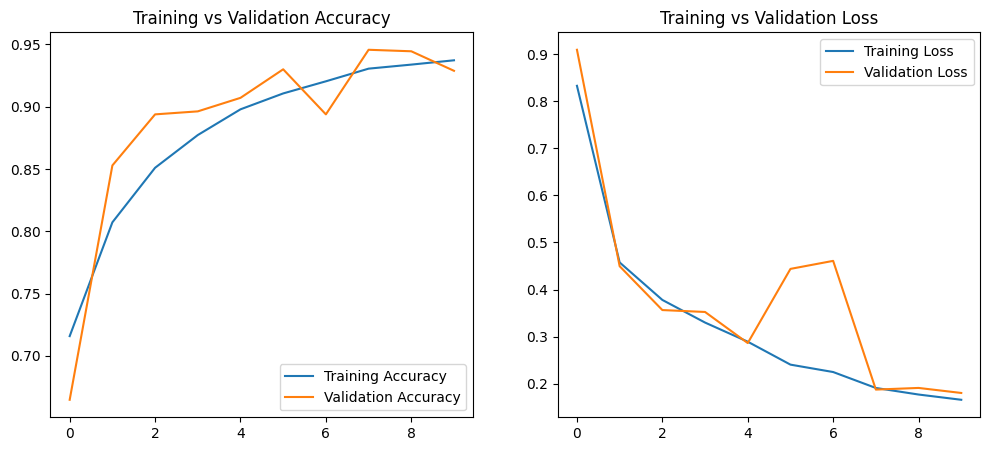

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


In [14]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Akurasi Training Terakhir: {final_train_acc:.2%}")
print(f"Akurasi Validation Terakhir: {final_val_acc:.2%}")

Akurasi Training Terakhir: 93.73%
Akurasi Validation Terakhir: 92.88%


In [15]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.9464 - loss: 0.1195
Test Loss: 0.2125
Test Accuracy: 0.9150
